In [ ]:
DATASET_PATH = 'DATASET'
# ===== Import library =====
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import graycomatrix, graycoprops
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ===== Konfigurasi ekstraksi fitur =====
IMAGE_SIZE = (128, 128) # ukuran resize untuk konsistensi
HIST_BINS = 32 # bins untuk histogram warna

In [11]:
def extract_features(image_path, resize=IMAGE_SIZE, hist_bins=HIST_BINS):
    """
    Ekstraksi fitur dari gambar:
    - Mean & std RGB
    - Histogram warna
    - Tekstur GLCM (contrast, homogeneity, energy)
    """

    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        # Jika gambar tidak bisa dibuka, lempar error ke pemanggil
        raise RuntimeError(f"Gagal membaca gambar: {image_path}") from e

    # Resize gambar
    img_res = img.resize(resize)
    arr = np.array(img_res)

    # Mean & std RGB
    mean_r = np.mean(arr[:, :, 0])
    mean_g = np.mean(arr[:, :, 1])
    mean_b = np.mean(arr[:, :, 2])
    std_r = np.std(arr[:, :, 0])
    std_g = np.std(arr[:, :, 1])
    std_b = np.std(arr[:, :, 2])

    # Histogram warna
    hist_r, _ = np.histogram(arr[:, :, 0], bins=hist_bins, range=(0, 255))
    hist_g, _ = np.histogram(arr[:, :, 1], bins=hist_bins, range=(0, 255))
    hist_b, _ = np.histogram(arr[:, :, 2], bins=hist_bins, range=(0, 255))

    # GLCM textures
    gray = img_res.convert("L")
    gray_arr = np.array(gray)

    glcm = graycomatrix(
        gray_arr, 
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast = graycoprops(glcm, "contrast")[0, 0]
    homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
    energy = graycoprops(glcm, "energy")[0, 0]

    # Gabungkan semua fitur
    features = [
        mean_r, mean_g, mean_b,
        std_r, std_g, std_b,
        contrast, homogeneity, energy
    ]

    features.extend(hist_r)
    features.extend(hist_g)
    features.extend(hist_b)

    # Tambah ukuran asli gambar (optional)
    features.append(img.size[0])
    features.append(img.size[1])

    return np.array(features, dtype=np.float32)


In [12]:
def build_feature_dataset(root_folder):
    """
    Membaca struktur folder:
        root_folder/
            O/ -> label 0
            R/ -> label 1

    Mengembalikan:
        DataFrame berisi fitur + label
    """
    rows = []
    labels = []
    filepaths = []

    classes = [('O', 0), ('R', 1)]

    for cls_name, cls_label in classes:
        folder = os.path.join(root_folder, cls_name)

        if not os.path.exists(folder):
            print(f"Folder tidak ditemukan: {folder}")
            continue

        print(f"Memproses folder: {folder}")

        for fname in tqdm(os.listdir(folder), desc=f'Folder {cls_name}'):
            fpath = os.path.join(folder, fname)

            if not os.path.isfile(fpath):
                continue

            # Ekstraksi fitur
            try:
                feats = extract_features(fpath)
                rows.append(feats)
                labels.append(cls_label)
                filepaths.append(fpath)
            except Exception as e:
                print(f"Gagal memproses {fpath}: {e}")
                continue

    if len(rows) == 0:
        raise ValueError("Tidak ada data berhasil diproses. Cek path folder DATASET.")

    X = np.vstack(rows)
    y = np.array(labels)

    df = pd.DataFrame(X)
    df["label"] = y
    df["filepath"] = filepaths

    return df


In [ ]:
# ===== Bangun dataset (TRAIN + TEST) =====
# NOTE: Jika dataset besar, kamu bisa memproses TRAIN saja dan split sendiri.


train_folder = os.path.join(DATASET_PATH, 'TRAIN')

print('Building TRAIN features...')
df_train = build_feature_dataset(train_folder)


Building TRAIN features...
Memproses folder: DATASET\TRAIN\O


Folder O: 100%|██████████| 12565/12565 [01:04<00:00, 194.45it/s]


Memproses folder: DATASET\TRAIN\R


Folder R: 100%|██████████| 9999/9999 [00:52<00:00, 191.19it/s]


In [14]:
test_folder = os.path.join(DATASET_PATH, 'TEST')

print('Building TEST features...')
df_test = build_feature_dataset(test_folder)

Building TEST features...
Memproses folder: DATASET\TEST\O


Folder O: 100%|██████████| 1401/1401 [00:07<00:00, 193.77it/s]


Memproses folder: DATASET\TEST\R


Folder R: 100%|██████████| 1112/1112 [00:05<00:00, 193.26it/s]


In [ ]:
# gabungkan dan split ulang (jika ingin stratified split)
df_all = pd.concat([df_train, df_test], ignore_index=True)
print(f"Total samples: {len(df_all)}")

Total samples: 25077


In [ ]:
# ===== Persiapan X, y =====n
feature_cols = [c for c in df_all.columns if c not in ['label','filepath']]
X = df_all[feature_cols].values
y = df_all['label'].values

In [ ]:
# ===== Scaling =====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# ===== Split (80%-20% atau gunakan struktur TRAIN/TEST asli jika diinginkan) =====
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


print('Train samples:', X_train.shape[0])
print('Validation samples:', X_val.shape[0])

Train samples: 20061
Validation samples: 5016


In [ ]:
# ===== Training Random Forest =====
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# ===== Evaluasi =====
y_pred = rf.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))
print('\nClassification Report:\n', classification_report(y_val, y_pred, digits=4))


# Confusion matrix (print)
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:\n', cm)

Accuracy: 0.842304625199362

Classification Report:
               precision    recall  f1-score   support

           0     0.8467    0.8754    0.8608      2794
           1     0.8364    0.8006    0.8181      2222

    accuracy                         0.8423      5016
   macro avg     0.8415    0.8380    0.8395      5016
weighted avg     0.8421    0.8423    0.8419      5016

Confusion Matrix:
 [[2446  348]
 [ 443 1779]]


In [ ]:
# ===== Simpan model & scaler & feature columns =====
MODEL_DIR = './model_files'
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, 'waste_rf_model.pkl')
scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
cols_path = os.path.join(MODEL_DIR, 'feature_columns.npy')


joblib.dump(rf, model_path)
joblib.dump(scaler, scaler_path)
np.save(cols_path, np.array(feature_cols))


print(f'Model saved to {model_path}')
print(f'Scaler saved to {scaler_path}')
print(f'Feature columns saved to {cols_path}')

Model saved to ./model_files\waste_rf_model.pkl
Scaler saved to ./model_files\scaler.pkl
Feature columns saved to ./model_files\feature_columns.npy


In [ ]:
# ===== export CSV fitur (opsional) =====
csv_out = os.path.join(MODEL_DIR, 'features_dataset.csv')
df_all.to_csv(csv_out, index=False)
print(f'Feature CSV saved to {csv_out}')

Feature CSV saved to ./model_files\features_dataset.csv


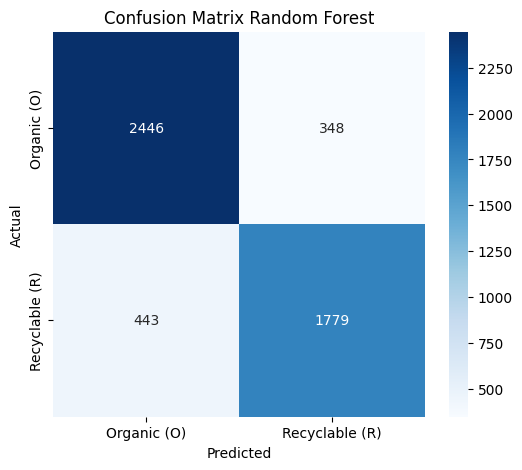

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Organic (O)','Recyclable (R)'],
            yticklabels=['Organic (O)','Recyclable (R)'])
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


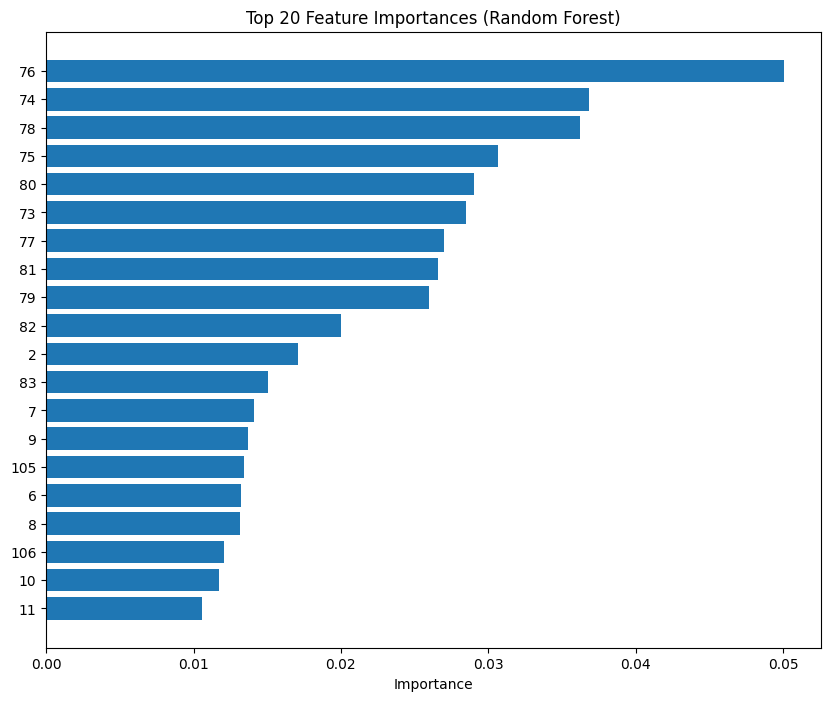

In [22]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # ambil 20 fitur teratas

plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(feature_cols)[indices])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


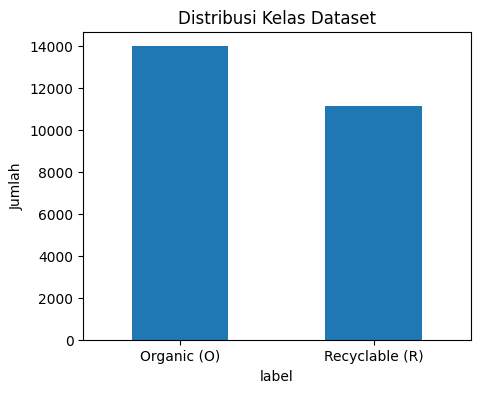

In [23]:
plt.figure(figsize=(5,4))
df_all['label'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Dataset')
plt.xticks([0,1], ['Organic (O)', 'Recyclable (R)'], rotation=0)
plt.ylabel('Jumlah')
plt.show()


DATASET\TRAIN\R\R_1547.jpg


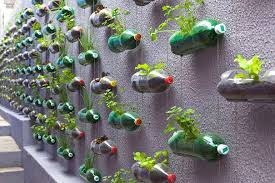

DATASET\TRAIN\R\R_2313.jpg


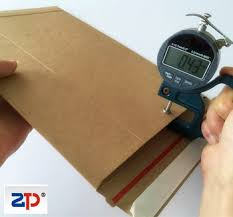

DATASET\TRAIN\R\R_4230.jpg


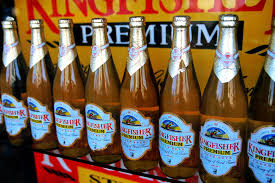

DATASET\TEST\R\R_10045.jpg


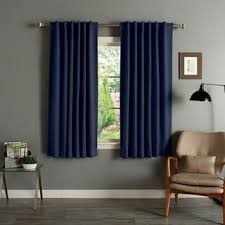

DATASET\TRAIN\O\O_400.jpg


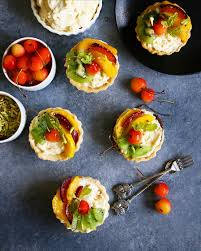

In [24]:
import random
from IPython.display import Image as IPImage, display

sample_files = random.sample(df_all['filepath'].tolist(), 5)

for file in sample_files:
    print(file)
    display(IPImage(filename=file))


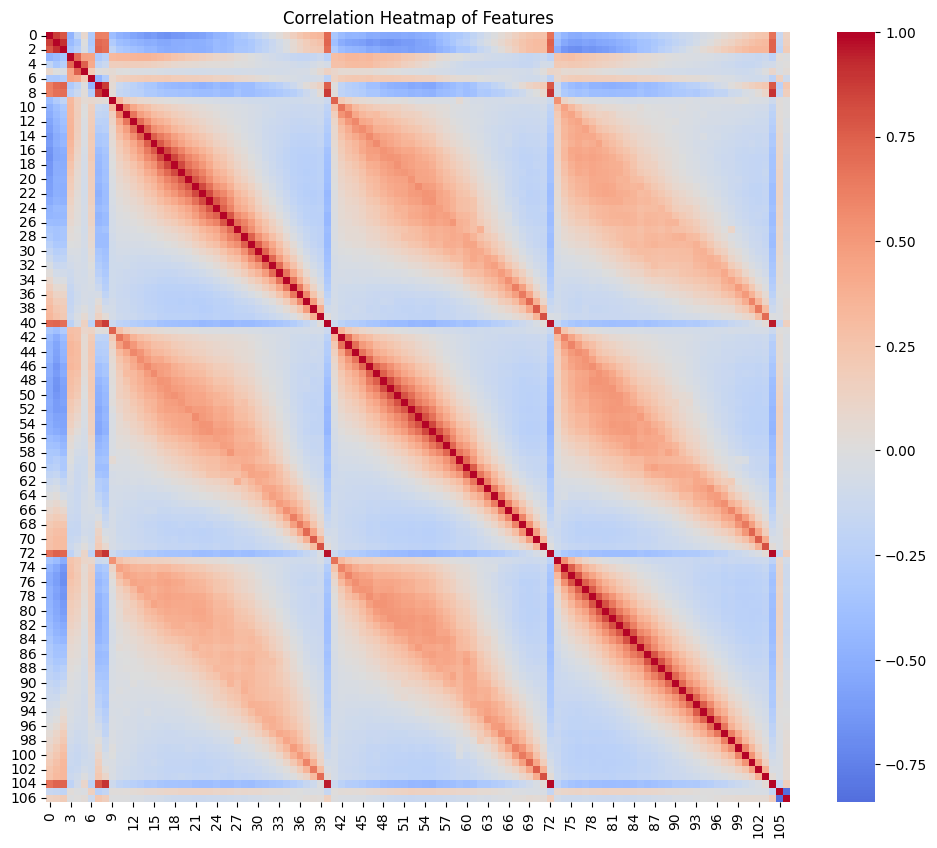

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df_all[feature_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()


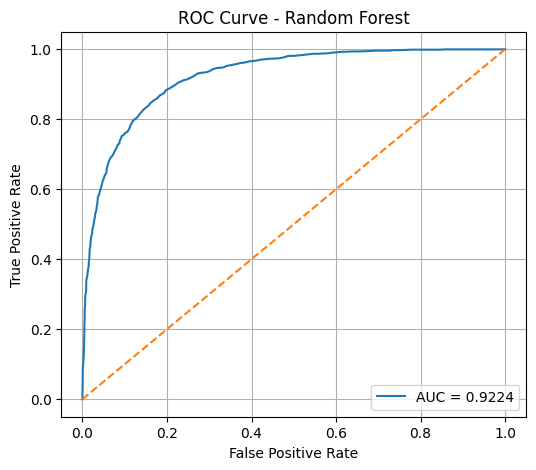

In [26]:
# ===== ROC Curve =====
from sklearn.metrics import roc_curve, auc

# Probabilitas kelas positif (Recyclable = 1)
y_prob = rf.predict_proba(X_val)[:, 1]

# Hitung ROC
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')  # garis random guess
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [28]:
# ===== Tabel ROC (FPR, TPR, Thresholds) =====

roc_table = pd.DataFrame({
    'FPR (False Positive Rate)': fpr,
    'TPR (True Positive Rate)': tpr,
    'Threshold': thresholds
})

# Tampilkan hanya 10 baris pertama agar tidak terlalu panjang
print("\nContoh 10 baris tabel ROC:")
print(roc_table.head(20))



Contoh 10 baris tabel ROC:
    FPR (False Positive Rate)  TPR (True Positive Rate)  Threshold
0                    0.000000                  0.000000        inf
1                    0.000000                  0.005401      1.000
2                    0.000358                  0.025203      0.995
3                    0.000716                  0.034653      0.990
4                    0.000716                  0.050405      0.985
5                    0.000716                  0.064806      0.980
6                    0.000716                  0.075158      0.975
7                    0.001074                  0.089559      0.970
8                    0.002147                  0.104410      0.965
9                    0.002863                  0.117462      0.960
10                   0.003221                  0.127813      0.955
11                   0.003579                  0.140864      0.950
12                   0.003937                  0.158416      0.945
13                   0.004295     